## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
#!curl https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv -o ./data/CreditScoring.csv

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('data/CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [4]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [5]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [6]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [7]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [8]:
categorical = [x for x in df.columns if df[x].dtype == 'object']
numerical = [x for x in df.columns if df[x].dtype != 'object']
numerical.pop(-1) # exclude the target variable 'default'

'default'

In [9]:
numerical

['seniority',
 'time',
 'age',
 'expenses',
 'income',
 'assets',
 'debt',
 'amount',
 'price']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

In [12]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [13]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [14]:
def train(df_train, y_train, features, solver='liblinear', C=1.0, max_iter=1000):
    dicts = df_train[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=max_iter, solver=solver)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model, features):
    dicts = df[features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [15]:
dv, model = train(df_train, y_train, features=numerical)
y_pred = predict(df_val, dv, model, features=numerical)

In [16]:
default_decision = (y_pred >= 0.5)
(y_val == default_decision).mean()

0.7643097643097643

In [17]:
from sklearn.metrics import roc_auc_score #, roc_curve, auc

In [18]:
scores = []

for feature in numerical:
    dv, model = train(df_train, y_train, features=[feature])
    y_pred = predict(df_val, dv, model, features=[feature])
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)

df_scores = pd.DataFrame(np.stack([numerical, scores], axis=1), columns=['feature', 'auc_score'])
df_scores.sort_values('auc_score',ascending=False)

,feature,auc_score
0,seniority,0.6903415894624062
4,income,0.6639944538980274
5,assets,0.6016890401462155
7,amount,0.588387848994769
2,age,0.5591668242263819
1,time,0.5528612844267977
3,expenses,0.512629986764984
6,debt,0.5076164366294826
8,price,0.46632318648767884


In [19]:
scores = []
for feature in numerical:
    score = (roc_auc_score(y_train, df_train[[feature]].values))
    if score >= 0.5:
        pass
    else:
        score = (roc_auc_score(y_train, -df_train[[feature]].values))
    scores.append(score)

df_scores = pd.DataFrame(np.stack([numerical, scores], axis=1), columns=['feature', 'auc_score'])
df_scores.sort_values('auc_score',ascending=False)

,feature,auc_score
0,seniority,0.7093778624491943
4,income,0.682006666132633
5,assets,0.6486042567122802
7,amount,0.5910773431595518
2,age,0.5732933272499939
1,time,0.5608662489595051
6,debt,0.5047829675783548
8,price,0.5043329862114843
3,expenses,0.5009184217217011


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [20]:
features = ['seniority', 'income', 'assets', 'records', 'job', 'home']

dv, model = train(df_train, y_train, features=features)
y_pred = predict(df_val, dv, model, features=features)

print('AUC score %.3f' % roc_auc_score(y_val, y_pred))

AUC score 0.812


## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [21]:
from sklearn.metrics import precision_score, recall_score

In [22]:
thresholds = np.linspace(0, 1, 101)

precision_scores = []
recall_scores = []

for t in thresholds:
    y_pred_tresh = (y_pred >= t).astype(int)
    precision_scores.append(precision_score(y_val, y_pred_tresh))
    recall_scores.append(recall_score(y_val, y_pred_tresh))


/Users/gur/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gur/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gur/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gur/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/metrics/_cl

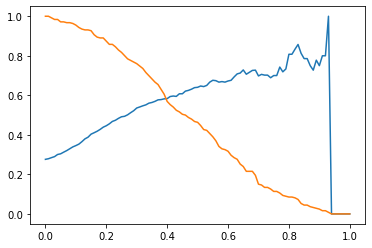

In [23]:
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [24]:
from sklearn.metrics import f1_score

In [25]:
thresholds = np.linspace(0, 1, 101)

f1_scores = []

for t in thresholds:
    y_pred_tresh = (y_pred >= t).astype(int)
    score = f1_score(y_val, y_pred_tresh)#precision_scores.append(precision_score(y_val, y_pred_tresh))
    f1_scores.append(score)

df_f1_scores = pd.DataFrame(np.stack([thresholds, f1_scores], axis=1), columns=['threshold', 'f1_score'])
df_f1_scores.sort_values('f1_score',ascending=False).head()

,threshold,f1_score
30,0.30,0.628571
31,0.31,0.627986
32,0.32,0.627383
33,0.33,0.623009
34,0.34,0.622061


<AxesSubplot:xlabel='threshold'>

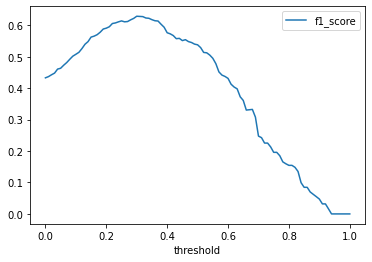

In [26]:
df_f1_scores.plot('threshold','f1_score')

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [27]:
from sklearn.model_selection import KFold

In [28]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train, features=features)
    y_pred = predict(df_val, dv, model, features=features)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.814 +- 0.015


In [29]:
scores

[0.8256212256212256,
 0.8254077031563476,
 0.7893383818254285,
 0.8250108084738436,
 0.8054696294614563]

How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std

In [30]:
from tqdm.auto import tqdm

In [31]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C, features=features)
        y_pred = predict(df_val, dv, model, features=features)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 25%|██▌       | 1/4 [00:00<00:01,  1.98it/s]

C=0.01 0.808 +- 0.012


 50%|█████     | 2/4 [00:00<00:00,  2.12it/s]

C=0.1 0.813 +- 0.014


 75%|███████▌  | 3/4 [00:01<00:00,  1.71it/s]

C=1 0.814 +- 0.015


100%|██████████| 4/4 [00:02<00:00,  1.71it/s]

C=10 0.814 +- 0.015


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

`C=1 0.814 +- 0.015`

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.